In [19]:
import numpy as np
import matplotlib.pyplot as plt
from lgca import get_lgca
from scipy.integrate import  solve_ivp
from scipy.special import erf
from math import sqrt
from scipy.ndimage import laplace, convolve1d
import seaborn as sns
import pickle as pkl
from plot_funcs import *

In [45]:
# figwidth = 6.224
# golden_ratio = 1.61803
# figsize = (figwidth, figwidth / golden_ratio)
import matplotlib as mpl
plt.style.use('default')
plt.style.use('thesis_style.mplstyle') # only activate for thesis, adjust height
# sns.set_style("ticks")
# sns.set_palette('colorblind')
# mpl.rcParams['figure.figsize'] = figsize
# mpl.rcParams['lines.linewidth'] = 2
# mpl.rcParams['font.size'] = 8
# plt.rcParams['svg.fonttype'] = 'path'

In [4]:
def gaussian(x):
    y = np.exp(-0.5 * x ** 2) / sqrt(2 * np.pi)
    return y


def cdf_gaussian(x):
    y = 0.5 * (1 + erf(x / sqrt(2)))
    return y


def trunc_gaussian(x, mu, sigma, a=0, b=1):
    """
    Truncated Gaussian distribution with mean mu and standard deviation sigma truncated to the interval [a,b]
    Parameters
    ----------
    x : array
    mu : float
    sigma : float
    a : float
    b : float

    Returns
    -------

    """
    xi = (x - mu) / sigma
    beta = (b - mu) / sigma
    alpha = (a - mu) / sigma
    y = gaussian(xi) / sigma
    y /= cdf_gaussian(beta) - cdf_gaussian(alpha)
    return y


def dydt_int(t, y, alpha, r_d, p, kernel):
    dalpha = alpha[1] - alpha[0]
    #     rho = y.sum() * dalpha
    rho = np.trapz(y, dx=dalpha)
    dy = np.empty_like(y)
    alpharho = alpha * y
    # for i, a in enumerate(alpha):
    #     dy[i] = np.trapz(alpha * y * kernel[i], dx=dalpha)
        
    dy = (1-p) * alpharho + p * np.trapz(alpharho * np.flip(kernel), dx=dalpha, axis=-1)

    #     dy = alpha * y + var * np.gradient(y, dalpha) + 0.5 * alpha * var * laplace(y) / dalpha**2
    dy *= 1 - rho
    dy -= r_d * y
    dy[0] = 0
    dy[-1] = 0  # neumann bcs
    return dy

def dydt_int_co(t, y, alpha, r_d, p, kernel, K):
    dalpha = alpha[1] - alpha[0]
    #     rho = y.sum() * dalpha
    rho = np.trapz(y, dx=dalpha)
    # dy = np.empty_like(y)
    cutoff = np.heaviside(y - 1/K, .5)
    alpharho = cutoff * alpha * y
    # for i, a in enumerate(alpha):
    #     dy[i] = np.trapz(alpha * y * kernel[i], dx=dalpha)

    dy = (1-p) * alpharho + p * np.trapz(alpharho * np.flip(kernel), dx=dalpha, axis=-1)
    # dy = (1-p) * alpharho + p * np.sum(alpharho * kernel, axis=-1) * dalpha
    #     dy = alpha * y + var * np.gradient(y, dalpha) + 0.5 * alpha * var * laplace(y) / dalpha**2
    dy *= 1 - rho
    dy -= r_d * y # * cutoff
    dy[0] = 0
    dy[-1] = 0  # neumann bcs
    return dy

def dydt_int_co_moran(t, y, alpha, r_d, p, kernel, K,):
    dalpha = alpha[1] - alpha[0]
    #     rho = y.sum() * dalpha
    rho = np.trapz(y, dx=dalpha)
    meanalpha = np.trapz(alpha * y, dx=dalpha) / rho
    r = alpha / meanalpha
    # calc palpha only if r != 1
    palpha = np.divide(1 - 1 / r, (1 - 1 / r ** K), where=~np.isclose(r, 1.), out=np.ones_like(r) / K)
    palpha[r <= 0] = 0.
    palpha[palpha < 1e-8] = 0.
    # palpha[r == 1] = 1 / K
    m = np.divide(- np.log(2), np.log(1 - palpha), where=palpha>0, out=np.ones_like(palpha)*K) / K
    # dy = np.empty_like(y)
    cutoff = np.heaviside(y - m, .5)
    alpharho = cutoff * alpha * y
    # for i, a in enumerate(alpha):
    #     dy[i] = np.trapz(alpha * y * kernel[i], dx=dalpha)

    dy = (1-p) * alpharho + p * np.trapz(alpharho * np.flip(kernel), dx=dalpha, axis=-1)
    # dy = (1-p) * alpharho + p * np.sum(alpharho * kernel, axis=-1) * dalpha
    #     dy = alpha * y + var * np.gradient(y, dalpha) + 0.5 * alpha * var * laplace(y) / dalpha**2
    dy *= 1 - rho
    dy -= r_d * y # * cutoff
    dy[0] = 0
    dy[-1] = 0  # neumann bcs
    return dy


# first order approximation
def dydt(t, y, alpha, r_d, p, mean, secondmoment):
    da = alpha[1] - alpha[0]
    rho = np.trapz(y, dx=da)
    alpharho = alpha * y
    dy = alpharho + p * (-mean * np.gradient(alpharho, da) + secondmoment / 2 * laplace(alpharho) / da**2)
    # dy = alpharho + v * (2 * np.gradient(y, da) + alpha * laplace(y) / da**2)
    # yL1 = y[-2] - y[-1] / alpha[-1] * 2 * da  # v = var / da**2 / 2
    # dy[-1] = alpharho[-1] - v / da**2 * (da * (yL1 - y[-2]) + alpha[-1] * (y[-2] - 2 * y[-1] + yL1))  # zero flux boundary condition (Robin)
    dy *= 1 - rho
    dy -= r_d * y
    dy[0] = 0 # Dirichlet, Robin and Neumann boundary amounts to the same at the left boundary
    dy[-1] = 0  # neumann condition
    return dy

def dydt_co(t, y, alpha, r_d, p, mean, secondmoment, K):
    da = alpha[1] - alpha[0]
    rho = np.trapz(y, dx=da)
    alpharho = alpha * y
    cutoff = np.heaviside(y - 1/K, .5)
    dy = cutoff * alpharho + p * (-mean * np.gradient(alpharho, da) + secondmoment / 2 * laplace(alpharho) / da**2)
    # dy = alpharho + v * (2 * np.gradient(y, da) + alpha * laplace(y) / da**2)
    # yL1 = y[-2] - y[-1] / alpha[-1] * 2 * da  # v = var / da**2 / 2
    # dy[-1] = alpharho[-1] - v / da**2 * (da * (yL1 - y[-2]) + alpha[-1] * (y[-2] - 2 * y[-1] + yL1))  # zero flux boundary condition (Robin)
    dy *= 1 - rho
    dy -= r_d * y # * cutoff
    dy[0] = 0 # Dirichlet, Robin and Neumann boundary amounts to the same at the left boundary
    dy[-1] = 0  # neumann condition
    return dy

def dydt_co_moran(t, y, alpha, r_d, p, mean, secondmoment, K):
    da = alpha[1] - alpha[0]
    rho = np.trapz(y, dx=da)
    alpharho = alpha * y
    meanalpha = np.trapz(alpha * y, dx=dalpha) / rho
    r = alpha / meanalpha
    palpha = np.divide(1 - 1 / r, (1 - 1 / r ** K), where=~np.isclose(r, 1.), out=np.ones_like(r) / K)
    palpha[r <= 0] = 0.
    palpha[palpha < 1e-8] = 0.
    # palpha[r == 1] = 1 / K
    m = np.divide(- np.log(2), np.log(1 - palpha), where=palpha>0, out=np.ones_like(palpha)*K) / K
    # dy = np.empty_like(y)
    cutoff = np.heaviside(y - m, .5)
    dy = cutoff * alpharho + p * (-mean * np.gradient(alpharho, da) + secondmoment / 2 * laplace(alpharho) / da**2)
    # dy = alpharho + v * (2 * np.gradient(y, da) + alpha * laplace(y) / da**2)
    # yL1 = y[-2] - y[-1] / alpha[-1] * 2 * da  # v = var / da**2 / 2
    # dy[-1] = alpharho[-1] - v / da**2 * (da * (yL1 - y[-2]) + alpha[-1] * (y[-2] - 2 * y[-1] + yL1))  # zero flux boundary condition (Robin)
    dy *= 1 - rho
    dy -= r_d * y # * cutoff
    dy[0] = 0 # Dirichlet, Robin and Neumann boundary amounts to the same at the left boundary
    dy[-1] = 0  # neumann condition
    return dy

# analytical predictions for bulk
def meanfitness(t, r_b, r_d, m, v0):
    """
    mean fitness over time in the bulk, given initial mean birth rate r_b, initial variance v0, mutationrate m
    """
    return np.sqrt(r_d**2 * m * t**2 + 2 * r_d * (v0+m) * t + r_b**2)


## Simulations with Gaussian mutations

In [60]:
a_max = 1.
a_min = 0.
na = 401
alpha, dalpha = np.linspace(a_min, a_max, num=na, retstep=True)
r_d = 0.05
r_b = 0.2
p_mut = 1
var = 1e-4
mean_mut_effect = 0.
tmax = 5000
Da = var / 2
dens0 = 1 - r_d / r_b
ts = np.linspace(0, tmax, num=101)
mu = np.linspace(-(a_max-a_min), a_max-a_min, 2 * na - 1)
basekernel = trunc_gaussian(mu, 0., sqrt(var), a=-(a_max-a_min), b=a_max-a_min)
kernel = np.array([trunc_gaussian(a - alpha, 0., sqrt(var), a=a_min - alpha, b=a_max - alpha) for a in alpha])
K = 100
# K *= 100 # l**2, did not work
y0 = np.zeros_like(alpha)
# y0[np.argwhere(alpha==r_b)] = dens0 / dalpha
# set y0 to dens0/dalapha at the point where alpha near r_b
y0[np.argmin(np.abs(alpha - r_b))] = dens0 / dalpha

In [6]:
meanalpha = np.trapz(alpha * y0, dx=dalpha) / dens0
r = alpha / meanalpha
palpha = np.divide(1 - 1 / r, (1 - 1 / r ** K), where=~np.isclose(r, 1.), out=np.ones_like(r) / K)
m = - np.log(2) / np.log(1 - palpha) / K
print(palpha, m)

[            nan 2.42697596e-159 1.49883572e-129 3.95554936e-112
 9.00000000e-100 3.43636543e-090 2.30384667e-082 9.48900703e-076
 5.07060240e-070 5.69339080e-065 1.86690458e-060 2.26086534e-056
 1.20254755e-052 3.20447221e-049 4.73859670e-046 4.21672737e-043
 2.41040707e-040 9.33623812e-038 2.56095268e-035 5.16210289e-033
 7.88860905e-031 9.38565631e-029 8.89444336e-027 6.84708240e-025
 4.35545749e-023 2.32355515e-021 1.05315029e-019 4.10163369e-018
 1.38620422e-016 4.10010845e-015 1.06906740e-013 2.47201480e-012
 5.09258994e-011 9.37516580e-010 1.54370725e-008 2.26833896e-007
 2.95134493e-006 3.33634899e-005 3.13462666e-004 2.21503875e-003
 1.00000000e-002 2.66457353e-002 4.79839410e-002 6.98179220e-002
 9.09156883e-002 1.11111963e-001 1.30434894e-001 1.48936185e-001
 1.66666669e-001 1.83673470e-001 2.00000000e-001 2.15686275e-001
 2.30769231e-001 2.45283019e-001 2.59259259e-001 2.72727273e-001
 2.85714286e-001 2.98245614e-001 3.10344828e-001 3.22033898e-001
 3.33333333e-001 3.442622

C:\Users\Simon Syga\AppData\Local\Temp\ipykernel_15736\1486820892.py:3: RuntimeWarning: divide by zero encountered in divide
  palpha = np.divide(1 - 1 / r, (1 - 1 / r ** K), where=~np.isclose(r, 1.), out=np.ones_like(r) / K)
C:\Users\Simon Syga\AppData\Local\Temp\ipykernel_15736\1486820892.py:3: RuntimeWarning: invalid value encountered in divide
  palpha = np.divide(1 - 1 / r, (1 - 1 / r ** K), where=~np.isclose(r, 1.), out=np.ones_like(r) / K)
C:\Users\Simon Syga\AppData\Local\Temp\ipykernel_15736\1486820892.py:4: RuntimeWarning: divide by zero encountered in divide
  m = - np.log(2) / np.log(1 - palpha) / K


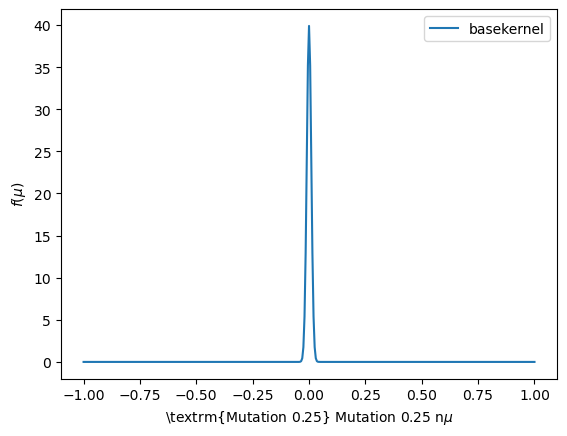

In [11]:
plt.plot(mu, basekernel, label='basekernel')
plt.xlabel(r'\textrm{Mutation 0.25} Mutation 0.25 n$\mu$')
plt.ylabel(r'$f(\mu)$')
plt.legend()

In [61]:
meanmu = np.trapz(mu * basekernel, dx=dalpha)
secondmommu = np.trapz(mu**2 * basekernel, dx=dalpha)

In [62]:
print(meanmu, mean_mut_effect, secondmommu, var + mean_mut_effect**2)

2.6020852139652106e-18 0.0 0.00010000000000000005 0.0001


In [101]:
# plot y0
# plt.plot(alpha, y0)

In [102]:
# dist = kernel[len(alpha)//2]
# means = np.array([np.trapz((alpha-alphai) * dist, dx=dalpha) for alphai in alpha])
# variances = np.array([np.trapz((alpha-alphai)**2 * dist, dx=dalpha) for alphai in alpha]) - means**2
# # print(-shape*scale, shape*scale**2, means[len(alpha)//2], variances[len(alpha)//2])
#
# plt.plot(alpha, kernel[100])
# plt.vlines(alpha[100], ymin=0, ymax=100, color='r')

In [103]:
# plt.plot(alpha, np.trapz(alpha * y0 * np.flip(kernel), dx=dalpha, axis=-1))
# plt.plot(alpha, y0, alpha=.1)

In [63]:
# method = 'DOP853'
method = 'RK45'

In [64]:
sol = solve_ivp(dydt_int_co, (0, tmax), y0, t_eval=ts, args=(alpha, r_d, p_mut, kernel, K), method=method, max_step=1.).y.T
# sol2 = solve_ivp(dydt_co, (0, tmax), y0, t_eval=ts, args=(alpha, r_d, p_mut, meanmu, secondmommu, K), method='DOP853')
sol2 = solve_ivp(dydt_co, (0, tmax), y0, t_eval=ts, args=(alpha, r_d, p_mut, 0., secondmommu, K), method=method, max_step=1.)

print(sol2.message)
sol2 = sol2.y.T

The solver successfully reached the end of the integration interval.


In [65]:
sol3 = solve_ivp(dydt_int, (0, tmax), y0, t_eval=ts, args=(alpha, r_d, p_mut, kernel), method=method, max_step=1.).y.T
sol4 = solve_ivp(dydt, (0, tmax), y0, t_eval=ts, args=(alpha, r_d, p_mut, meanmu, secondmommu), method=method, max_step=1.)
# sol3 = solve_ivp(dydt_int_co, (0, tmax), y0, t_eval=ts, args=(alpha, r_d, p_mut, kernel, K), method=method, max_step=1.).y.T
# sol2 = solve_ivp(dydt_co, (0, tmax), y0, t_eval=ts, args=(alpha, r_d, p_mut, meanmu, secondmommu, K), method='DOP853')
# sol4 = solve_ivp(dydt_co, (0, tmax), y0, t_eval=ts, args=(alpha, r_d, p_mut, 0., secondmommu, K), method=method, max_step=1.)
print(sol4.message)
sol4 = sol4.y.T

The solver successfully reached the end of the integration interval.


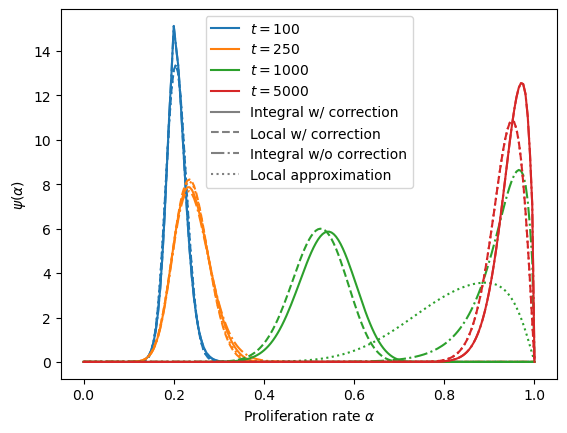

In [18]:
for t in [2, 5, 20, 100]:
    p = plt.plot(alpha, sol[t], label='$t = {:n}$'.format(ts[t]))
    plt.plot(alpha, sol2[t], '--', label='_t = {:n}'.format(ts[t]), color=p[0].get_color())
    plt.plot(alpha, sol3[t], '-.', label='_t = {:n}'.format(ts[t]), color=p[0].get_color())
    plt.plot(alpha, sol4[t], ':', label='_t = {:n}'.format(ts[t]), color=p[0].get_color())


#plt.plot(alpha, sol[-1], label='t = {:n}'.format(ts[-1]))
# p = plt.plot(alpha, sol[t], label='t = {:n}'.format(ts[t]))
# plt.plot(alpha, sol2[t], '--', label='_t = {:n}'.format(ts[t]), color=p[0].get_color())
plt.xlabel('Proliferation rate $\\alpha$')
plt.ylabel('$\\psi(\\alpha)$')
leg = plt.legend()
lines, labels = plt.gca().get_legend_handles_labels()

# add new lines and labels
lines += [plt.Line2D([0], [0], ls=ls, c='gray') for ls in ['-', '--', '-.', ':']]
labels += ['Integral w/ correction', 'Local w/ correction', 'Integral w/o correction', 'Local approximation']

# create a new legend with all lines and labels
plt.legend(lines, labels)


In [17]:
# idea: test model variant, w/ death term ~ r_d + r_b * rho! - done!
# check initial condition, cell number is wrong! -> calc correct density! - done! 
# allow any distribution in lgca
# check

In [18]:
# # lgca = get_lgca(ib=True, density=dens0, bc='reflect', interaction='birthdeath', std=sqrt(var),
#                 r_d=r_d, r_b=r_b, a_max=a_max, geometry='1d', dims=1, restchannels=K-2)
l = 10
dims= l, l
lgca = get_lgca(ib=True, density=dens0*K/7, bc='pbc', interaction='birthdeath', std=sqrt(var), ve=False, capacity=K,
                r_d=r_d, r_b=r_b, a_max=a_max, geometry='hx', dims=dims, restchannels=1)
  #  set lgca.propagation to function that does nothing to isolate nodes
lgca.propagation = lambda : None  # turned off propagation so that each
lgca.timeevo(timesteps=tmax, record=True)

Rest channel weight set to gamma = 0.0


100%|██████████| 5000/5000 [39:41<00:00,  2.10it/s]


In [33]:
# load lgca with pickle
# with open('lgca.pickle', 'rb') as f:
#     lgca = pkl.load(f)

In [20]:
#  lgca.propagation as it cannot be pickled
# del lgca.propagation

In [20]:
# save lgca with pickle
# with open('lgca_gaussian_100_wellmixed.pickle', 'wb') as f:
#     pkl.dump(lgca, f)

NameError: name 'lgca' is not defined

In [66]:
# calc observables
rhoint_co = np.trapz(sol, dx=dalpha)
rholoc_co = np.trapz(sol2, dx=dalpha)
rhoint = np.trapz(sol3, dx=dalpha)
rholoc = np.trapz(sol4, dx=dalpha)
meanalphaint_co = np.trapz(sol * alpha, dx=dalpha) / rhoint_co
meanalphaloc_co = np.trapz(sol2 * alpha, dx=dalpha) / rholoc_co
meanalphaint = np.trapz(sol3 * alpha, dx=dalpha) / rhoint
meanalphaloc = np.trapz(sol4 * alpha, dx=dalpha) / rholoc
meanalphaana = meanfitness(ts, r_b, r_d, var, 0)
rhoana = 1 - r_d / meanalphaana

In [67]:
var_ana = r_d * var * ts
varint_co = np.trapz(sol * alpha**2, dx=dalpha) / rhoint_co - meanalphaint_co**2
varloc_co = np.trapz(sol2 * alpha**2, dx=dalpha) / rholoc_co - meanalphaloc_co**2
varint = np.trapz(sol3 * alpha**2, dx=dalpha) / rhoint - meanalphaint**2
varloc = np.trapz(sol4 * alpha**2, dx=dalpha) / rholoc - meanalphaloc**2

In [36]:
def get_prop_spatiotemp(self, nodes=None, props=None, propname=None):
    """
    Return array of property "propname" on every node, given the lattice configuration "nodes" and the property
    dictionary "props".
    """
    if nodes is None:
        nodes = self.nodes[self.nonborder]

    if props is None:
        props = self.props

    if propname is None:
        propname = next(iter(self.props))

    cells = nodes.sum(-1)
    prop = np.ma.masked_all(cells.shape, dtype=object)
    proparray = np.array(props[propname])
    for ind, loccells in np.ndenumerate(cells):
        if loccells:
            nodeprops = proparray[loccells]
            prop[ind] = list(nodeprops)
            prop.mask[ind] = 0
    return prop

In [37]:
prop = np.array(lgca.props['r_b'])
cells_t = lgca.nodes_t.sum((1, 2, 3))

In [38]:
prop_t = [prop[cells] for cells in cells_t]  # for averaging over space
# prop_t = get_prop_spatiotemp(lgca, nodes=lgca.nodes_t)
mean_prop_t = np.array([np.mean(prop) if len(prop) > 0 else np.nan for prop in prop_t])  # for averaging over space
# mean_prop_t = np.ma.masked_all(prop_t.shape)
# for ind, prop in np.ndenumerate(prop_t):
#     if len(prop) > 0:
#         mean_prop_t[ind] = np.mean(prop)

# std_mean_prop_t = np.ma.masked_all(prop_t.shape)
# for ind, prop in np.ndenumerate(prop_t):
#     if len(prop) > 0:
#         std_mean_prop_t[ind] = np.std(prop, ddof=1) / np.sqrt(len(prop))
# std_mean_prop_t = np.array([np.std(prop, ddof=1) / np.sqrt(len(prop)) if len(prop) > 0 else np.nan for prop in prop_t])  # for averaging over space
std_mean_prop_t = np.array([np.std(prop, ddof=1) if len(prop) > 0 else np.nan for prop in prop_t])


In [39]:
var_prop_t = np.array([np.var(prop, ddof=1) if len(prop) > 0 else np.nan for prop in prop_t])  # for averaging over space
# var_prop_t = np.ma.masked_all(prop_t.shape)
# for ind, prop in np.ndenumerate(prop_t):
#     if len(prop) > 0:
#         var_prop_t[ind] = np.var(prop, ddof=1)

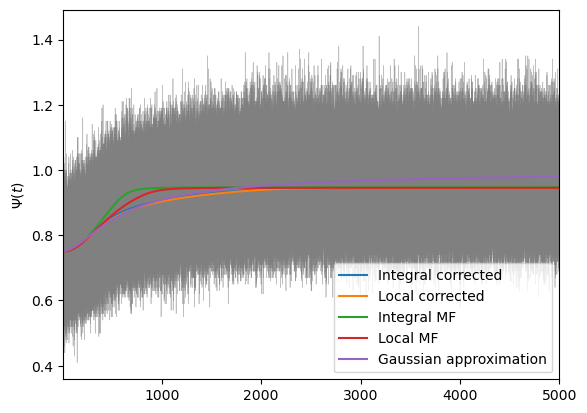

In [40]:

# plt.plot(np.arange(len(lgca.dens_t)), lgca.dens_t.mean(-1).mean(-1)/lgca.interaction_params['capacity'], label='LGCA', alpha=.6)
# plt.plot(np.arange(len(lgca.dens_t)), lgca.dens_t.mean((1,2))/lgca.interaction_params['capacity'], color='gray', label='LGCA', alpha=.5)  # for averaging over space
plt.plot(np.arange(len(lgca.dens_t)), lgca.dens_t.reshape(len(lgca.dens_t), -1)/lgca.interaction_params['capacity'], color='gray', label='_LGCA', alpha=.5, lw=.5)  # for averaging over space
plt.plot(ts, rhoint_co, label='Integral corrected')
plt.plot(ts, rholoc_co, label='Local corrected')
plt.plot(ts, rhoint, label='Integral MF')
plt.plot(ts, rholoc, label='Local MF')
plt.plot(ts, rhoana, label='Gaussian approximation')
# plt.plot(np.arange(len(lgca.dens_t)), lgca.dens_t/lgca.interaction_params['capacity'], label='LGCA', alpha=.7)
plt.title('')
plt.xlim(10, 5000)
# plt.ylim(.45, 1)
plt.ylabel('$\\Psi (t)$')
plt.legend()
# sns.despine()
# plt.xscale('log')

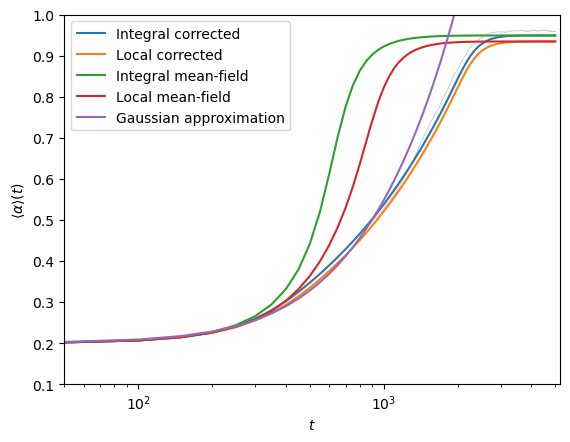

In [41]:
yerr = std_mean_prop_t.reshape(len(lgca.dens_t), -1)
x = np.arange(tmax+1)
y = mean_prop_t.reshape(len(lgca.dens_t), -1)

plt.plot(ts, meanalphaint_co, label='Integral corrected')
plt.plot(ts, meanalphaloc_co, label='Local corrected')
plt.plot(ts, meanalphaint, label='Integral mean-field')
plt.plot(ts, meanalphaloc, label='Local mean-field')
plt.plot(ts, meanalphaana, label='Gaussian approximation')
# plt.plot(np.arange(len(lgca.dens_t)), lgca.dens_t.mean(-1).mean(-1)/lgca.interaction_params['capacity'], label='LGCA', alpha=.6)
line = plt.plot(x, y, color='gray', label='_LGCA', alpha=.5, lw=.5)
# errors = plt.fill_between(x, y - yerr, y + yerr, alpha=0.5, color='k', antialiased=True, interpolate=True)
# plt.plot(np.arange(len(lgca.dens_t)), lgca.dens_t/lgca.interaction_params['capacity'], label='LGCA', alpha=.7)
plt.title('')
plt.xlim(50)
plt.ylim(0.1, 1)
plt.ylabel('$\\langle\\alpha\\rangle (t)$')
plt.xlabel('$t$')
plt.legend()
# sns.despine()
plt.xscale('log')

[]

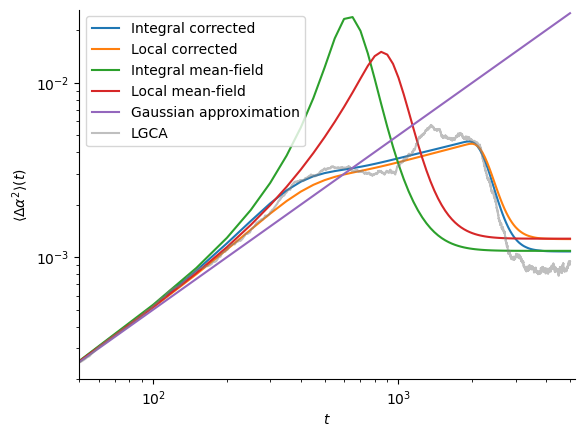

In [42]:
# yerr = std_mean_prop_t
x = np.arange(tmax+1)
y = var_prop_t
# errors = plt.fill_between(x, y - yerr, y + yerr, alpha=0.5, color='gray', antialiased=True, interpolate=True)
plt.plot(ts, varint_co, label='Integral corrected')
plt.plot(ts, varloc_co, label='Local corrected')
plt.plot(ts, varint, label='Integral mean-field')
plt.plot(ts, varloc, label='Local mean-field')
plt.plot(ts, var_ana, label='Gaussian approximation')
line = plt.plot(x, y, color='gray', label='LGCA', alpha=.5)

plt.title('')
plt.xlim(50)
plt.ylim(2e-4)
plt.ylabel('$\\langle\\Delta\\alpha^2\\rangle (t)$')
plt.xlabel('$t$')
plt.legend()
sns.despine()
# plt.xscale('log')
plt.loglog()

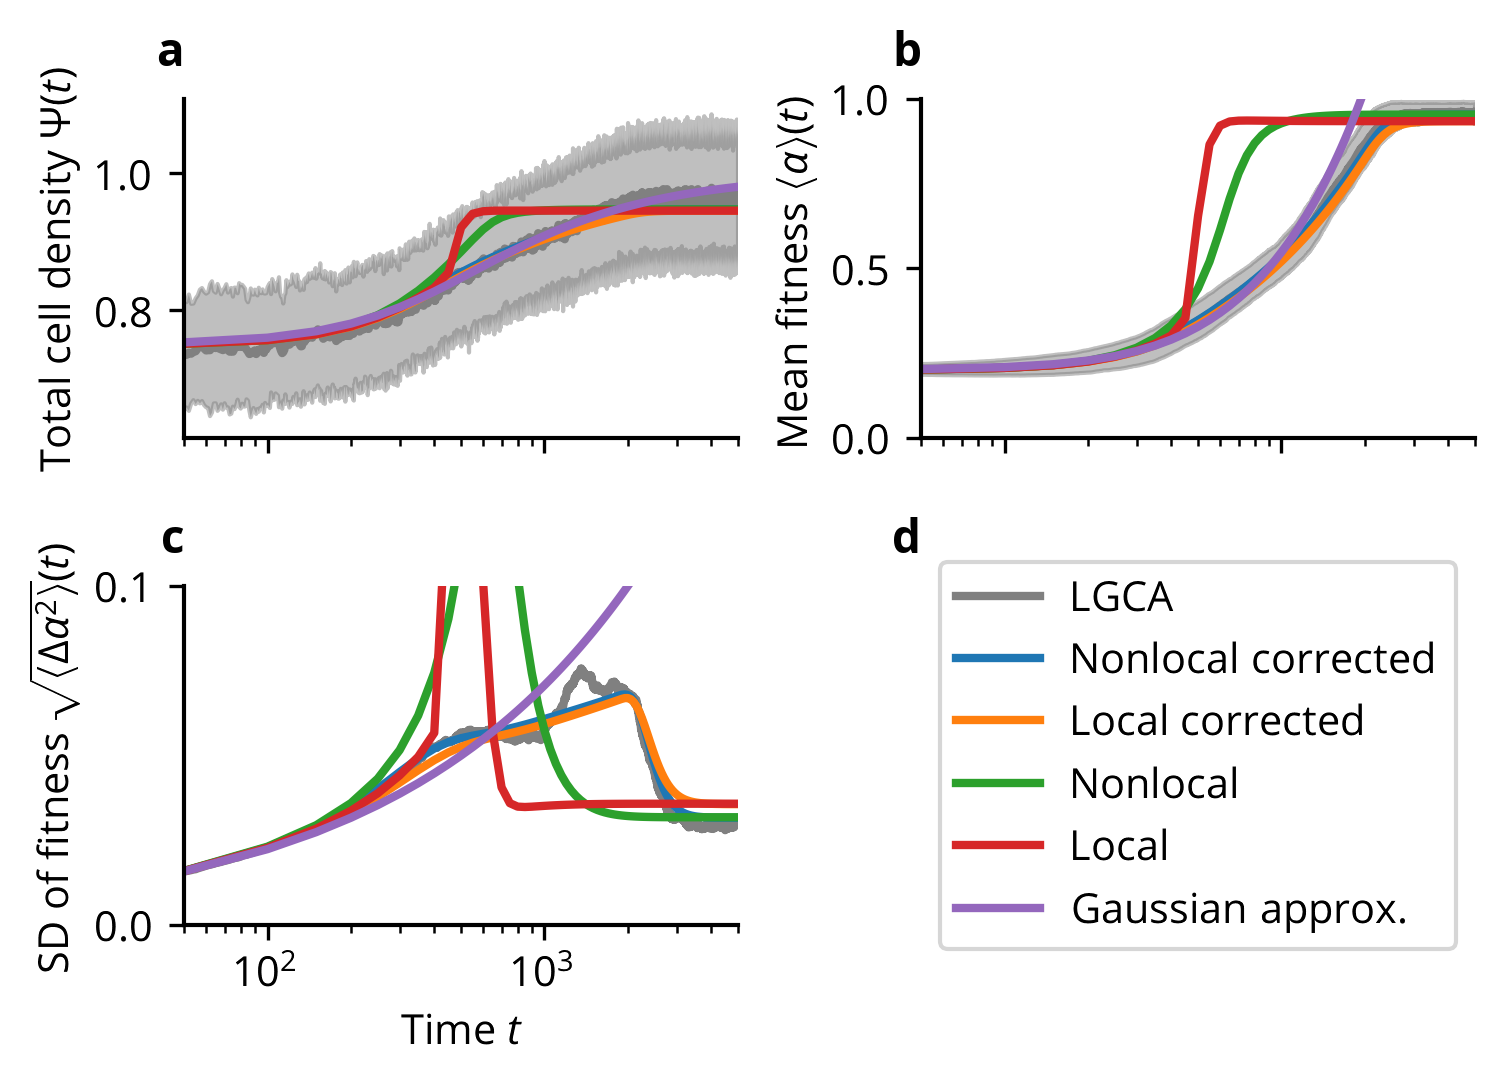

In [85]:
# set golden_ratio
golden_ratio = (np.sqrt(5) + 1.0) / 2.0
# get default figsize
wi, le = plt.rcParams['figure.figsize']
# wi = 0.5 * wi
# le = wi / golden_ratio * 2

fig = plt.figure(constrained_layout=True, figsize=(wi, le))# , nrows=2, ncols=2, sharey=True, sharex=True, figsize=(wi, 0.9*wi/golden_ratio),
                        # gridspec_kw={'hspace': 0.1, 'wspace': 0.1}, tight_layout=True)
# ax = fig.subplots(3, 1, sharey=False, sharex=True, gridspec_kw={'hspace': 0.1, 'wspace': 0.05})
ax = fig.subplots(2, 2, sharey=False, sharex=True, gridspec_kw={'hspace': 0.1, 'wspace': 0.05})

# plt.sca(ax[0])
plt.sca(ax[0, 0])  # first plot

x = np.arange(tmax+1)
y =  lgca.dens_t.mean((1,2))/lgca.interaction_params['capacity']
yerr = lgca.dens_t.std((1,2), ddof=1)/lgca.interaction_params['capacity']  # /np.sqrt(lgca.dens_t.shape[1]*lgca.dens_t.shape[2])

plt.plot(x, y, color='gray', label='LGCA')
errors = plt.fill_between(x, y - yerr, y + yerr, alpha=.5, color='gray', antialiased=True, interpolate=True)
plt.plot(ts, rhoint_co, label='Nonlocal corrected')
plt.plot(ts, rholoc_co, label='Local corrected')
plt.plot(ts, rhoint, label='Nonlocal MF')
plt.plot(ts, rholoc, label='Local MF')
plt.plot(ts, rhoana, label='Gaussian appr.')
# plt.plot(np.arange(len(lgca.dens_t)), lgca.dens_t.mean(-1).mean(-1)/lgca.interaction_params['capacity'], label='LGCA', alpha=.6)
# plt.plot(np.arange(len(lgca.dens_t)), lgca.dens_t.reshape(len(lgca.dens_t), -1)/lgca.interaction_params['capacity'], color='gray', label='_LGCA', alpha=.5)
# plot mean over space

# plt.plot(ts, rhoint_co, label='Nonlocal corrected', c='k')
# plt.plot(np.arange(len(lgca.dens_t)), lgca.dens_t/lgca.interaction_params['capacity'], label='LGCA', alpha=.7)
# plt.ylim(.45, 1)
plt.ylabel('Total cell density $\\Psi (t)$')
# plt.legend()
# plt.xscale('log')

# plt.sca(ax[1])
plt.sca(ax[0, 1])  # second plot

yerr = std_mean_prop_t
y = mean_prop_t  # .reshape(len(lgca.dens_t), -1)
yerr = std_mean_prop_t
errors = plt.fill_between(x, y - yerr, y + yerr, alpha=0.5, color='gray', antialiased=True, interpolate=True)
plt.plot(x, y, color='gray', label='LGCA')
plt.plot(ts, meanalphaint_co, label='Nonlocal corrected')
plt.plot(ts, meanalphaloc_co, label='Local corrected')
plt.plot(ts, meanalphaint, label='Nonlocal')
plt.plot(ts, meanalphaloc, label='Local')
plt.plot(ts, meanalphaana, label='Gaussian approx.')
# plt.plot(np.arange(len(lgca.dens_t)), lgca.dens_t.mean(-1).mean(-1)/lgca.interaction_params['capacity'], label='LGCA', alpha=.6)
# line = plt.plot(x, y, color='gray', label='_LGCA', alpha=.5, lw=.25)

# plt.plot(ts, meanalphaint_co, label='Mean-field prediction', c='k')

# plt.plot(np.arange(len(lgca.dens_t)), lgca.dens_t/lgca.interaction_params['capacity'], label='LGCA', alpha=.7)
plt.title('')
# plt.xlim(50)
plt.ylim(0., 1)
plt.yticks([0, .5, 1])
plt.ylabel('Mean fitness $\\langle\\alpha\\rangle (t)$')
# plt.xlabel('$t$')
# plt.legend(fontsize='small')
# sns.despine()
# plt.xscale('log')
# plt.sca(ax[-1])
plt.sca(ax[1, 0])  # third plot

# x = np.arange(tmax+1)
y = var_prop_t
x = np.arange(tmax+1)
# y = mean_prop_t
# errors = plt.fill_between(x, y - yerr, y + yerr, alpha=0.5, color='gray', antialiased=True, interpolate=True)
# plt.plot(ts, varint_co, label='Integral corrected')
# plt.plot(ts, varloc_co, label='Local corrected')
# plt.plot(ts, varint, label='Integral mean-field')
# plt.plot(ts, varloc, label='Local mean-field')
# plt.plot(ts, var_ana, label='Gaussian approx.')
# Applying np.sqrt to y-coordinates
varint_co_sqrt = np.sqrt(varint_co)
varloc_co_sqrt = np.sqrt(varloc_co)
varint_sqrt = np.sqrt(varint)
varloc_sqrt = np.sqrt(varloc)
var_ana_sqrt = np.sqrt(var_ana)

# Plotting
# plt.plot(ts, varint_co_sqrt, label='Integral corrected')
line = plt.plot(x, np.sqrt(y), color='gray', label='LGCA', alpha=1)
plt.plot(ts, varint_co_sqrt, label='Nonlocal corrected',)
plt.plot(ts, varloc_co_sqrt, label='Local corrected')
plt.plot(ts, varint_sqrt, label='Integral mean-field')
plt.plot(ts, varloc_sqrt, label='Local mean-field')
plt.plot(ts, var_ana_sqrt, label='Gaussian approx.')

# plt.plot(ts, varint_co_sqrt, label='Nonlocal corrected', c='k')
plt.title('')
plt.xlim(50, tmax)
plt.ylim(0, 0.1)
plt.yticks([0, .1])
plt.ylabel(r'SD of fitness $\sqrt{\langle\Delta\alpha^2\rangle} (t)$')
plt.xlabel('Time $t$')
plt.xscale('log')
# plt.loglog()
label_axes(fig)

handles, labels = ax[0,1].get_legend_handles_labels()
ax[1, 1].legend(handles, labels, loc='center')
ax[1, 1].axis('off')  # turn off axis

plt.savefig('moment_comparison_gaussian_mixedlgca.pdf', bbox_inches='tight', pad_inches=0)

In [49]:
wi, le = plt.rcParams['figure.figsize']
print(wi, le, golden_ratio)

4.9 3.5 0.6180339887498949


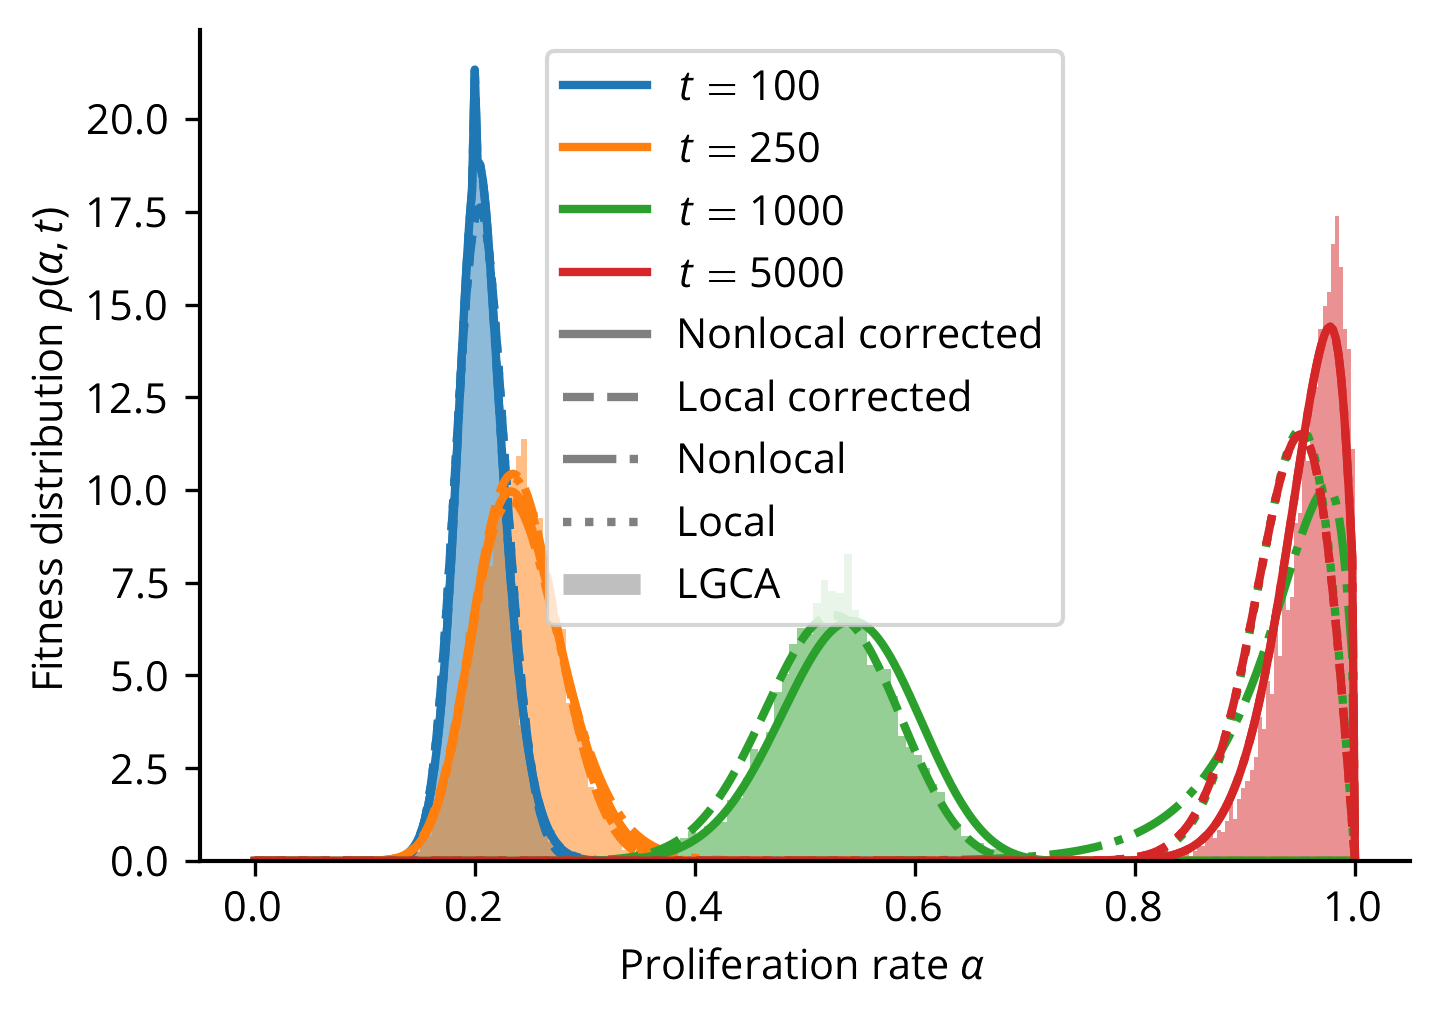

In [69]:
golden_ratio = (np.sqrt(5) + 1.0) / 2.0
# get default figsize
wi, le = plt.rcParams['figure.figsize']
# wi *= 0.7
# le = wi / golden_ratio
plt.figure(figsize=(wi, le))

for t in [2, 5, 20, 100]:
    p = plt.plot(alpha, sol[t]/rhoint_co[t], label='$t = {:n}$'.format(ts[t]))
    # p = plt.plot(alpha, sol2[t]/rholoc_co[t], label='$t = {:n}$'.format(ts[t]))
    plt.plot(alpha, sol2[t]/rholoc_co[t], '--', label='_t = {:n}'.format(ts[t]), color=p[0].get_color())
    plt.plot(alpha, sol3[t]/rhoint[t], '-.', label='_t = {:n}'.format(ts[t]), color=p[0].get_color())
    plt.plot(alpha, sol4[t]/rholoc[t], ':', label='_t = {:n}'.format(ts[t]), color=p[0].get_color())
    plt.hist(lgca.get_prop(nodes=lgca.nodes_t[round(ts[t])]), bins='auto', density=True, color=p[0].get_color(), alpha=.5, edgecolor='none')


#plt.plot(alpha, sol[-1], label='t = {:n}'.format(ts[-1]))
# p = plt.plot(alpha, sol[t], label='t = {:n}'.format(ts[t]))
# plt.plot(alpha, sol2[t], '--', label='_t = {:n}'.format(ts[t]), color=p[0].get_color())
plt.xlabel('Proliferation rate $\\alpha$')
plt.ylabel('Fitness distribution $\\rho(\\alpha, t)$')
leg = plt.legend()
lines, labels = plt.gca().get_legend_handles_labels()

# add new lines and labels
lines += [plt.Line2D([0], [0], ls=ls, c='gray') for ls in ['-', '--', '-.', ':']]
labels += ['Nonlocal corrected', 'Local corrected', 'Nonlocal', 'Local']

# lines += [plt.Line2D([0], [0], ls=ls, c='gray') for ls in ['-']]
# labels += ['Mean-field prediction']

# add legend entry for histogram with bar symbol
lines += [plt.Line2D([0], [0], ls='--', color='gray', lw=5, alpha=.5)]
labels += ['LGCA']

# create a new legend with all lines and labels
plt.legend(lines, labels)
plt.tight_layout()
# plt.savefig('density_comparison_gaussian_mixedlgca.pdf', bbox_inches='tight', pad_inches=0)

C:\ProgramData\anaconda3\envs\py311\Lib\site-packages\IPython\core\events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
C:\ProgramData\anaconda3\envs\py311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


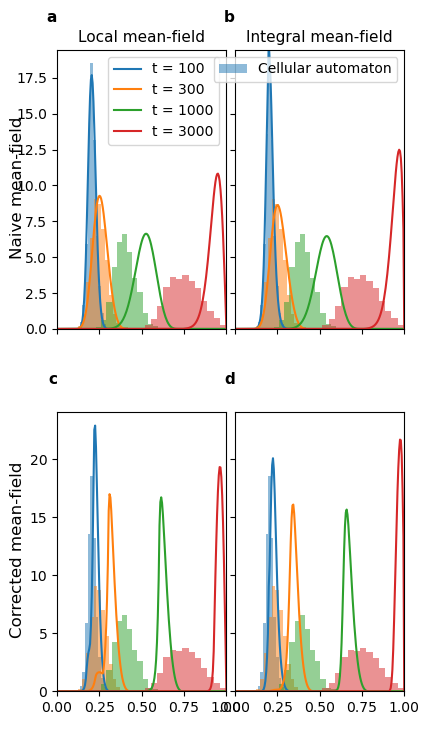

In [115]:
# wi = figwidth
lw = 2
fig = plt.figure(figsize=(wi, le), tight_layout=True)# , nrows=2, ncols=2, sharey=True, sharex=True, figsize=(wi, 0.9*wi/golden_ratio),
                        # gridspec_kw={'hspace': 0.1, 'wspace': 0.1}, tight_layout=True)
subfigs = fig.subfigures(2, 1)
axsup = subfigs[0].subplots(1, 2, sharey=True, sharex=True, gridspec_kw={'hspace': 0.1, 'wspace': 0.05})
subfigs[0].supylabel('Naive mean-field')
axsdown = subfigs[1].subplots(1, 2, sharey=True, sharex=True, gridspec_kw={'hspace': 0.1, 'wspace': 0.05})
subfigs[1].supylabel('Corrected mean-field')
fig.supylabel('Fitness distribution $\\rho(\\alpha, t)$')
fig.supxlabel('Fitness $\\alpha$')
# for t in np.linspace(1, len(ts)/1.5, 4, dtype=int, endpoint=False):
for t in (100, 300, 1000, 3000):
    t = (np.abs(ts - t)).argmin()
    # plt.sca(axsup[0])
    axsup[0].set_title('Local mean-field', fontsize=11)
    # axsup[0].set_ylabel('$\\rho(\\alpha, t)$')
    # .ylabel('No correction')
    p = axsup[0].plot(alpha, sol4[t] / rholoc[t], label='t = {:n}'.format(ts[t]))
    bins = round(np.ceil(np.log2(lgca.dens_t[round(ts[t])].sum()))+1) 
    axsup[0].hist(lgca.get_prop(nodes=lgca.nodes_t[round(ts[t])]), bins=bins, density=True, color=p[0].get_color(), alpha=.5)
    axsup[0].legend()
    axsup[0].set_xticklabels([])
    # plt.plot(alpha, sol2[t], '--', label='_t = {:n}'.format(ts[t]), color=p[0].get_color())
    # plt.sca(axsup[1])
    axsup[1].set_title('Integral mean-field', fontsize=11)
    axsup[0].set_ylim(0)
    axsup[0].set_xlim(0, 1)
   
    p = axsup[1].plot(alpha, sol3[t] / rhoint[t], label='_t = {:n}'.format(ts[t]))
    axsup[1].hist(lgca.get_prop(nodes=lgca.nodes_t[round(ts[t])]), bins=bins, density=True, color=p[0].get_color(), alpha=.5)

    
    # plt.plot(alpha, trunc_gaussian(alpha, meanalphaana[t], sqrt(var_ana[t]), a=0, b=1), '-.', color=p[0].get_color())
    
    # plt.sca(axsdown[0])
    # plt.ylabel('Low-density correction')
    # axsdown[0].set_xlabel('$\\alpha$')
    axsdown[0].hist(lgca.get_prop(nodes=lgca.nodes_t[round(ts[t])]), bins=bins, density=True, color=p[0].get_color(), alpha=.5)
    p = axsdown[0].plot(alpha, sol2[t] / rholoc_co[t], label='t = {:n}'.format(ts[t]))
    # axsdown[0].set_ylabel('$\\rho(\\alpha, t)$')

    # plt.plot(alpha, trunc_gaussian(alpha, meanalphaana[t], sqrt(var_ana[t]), a=0, b=1), '-.', color=p[0].get_color())
    
    # plt.sca(axsdown[1])
    axsdown[1].hist(lgca.get_prop(nodes=lgca.nodes_t[round(ts[t])]), bins=bins, density=True, color=p[0].get_color(), alpha=.5)
    p = axsdown[1].plot(alpha, sol[t] / rhoint_co[t], label='$t = {:n}$'.format(ts[t]))
    # axsdown[1].set_xlabel('$\\alpha$')
    # plt.plot(alpha, trunc_gaussian(alpha, meanalphaana[t], sqrt(var_ana[t]), a=0, b=1), '-.', color=p[0].get_color())

h = axsup[1].hist(lgca.get_prop(nodes=lgca.nodes_t[round(ts[-1])]), bins=bins, density=True, color='C0', visible=True, label='Cellular automaton', alpha=.5)
axsup[1].legend()
for rect in h[2].patches:
    rect.set_visible(False)
# fig.supxlabel('$\\alpha$')
# fig.supylabel('$\\rho(\\alpha)$')
plt.ylim(0)
plt.xlim(0, 1)
# sns.despine()
label_axes(fig)
# plt.savefig('mean-field_comparison.pdf', bbox_inches='tight', pad_inches=0)